20240726 접촉 Stiffness 시뮬레이션 비교

* 필요 패키지 사용

In [69]:
import numpy as np
import mujoco
import mujoco.viewer
import mediapy as media

import time
import serpenoid
import serpenoid_gamma

from scipy.signal import find_peaks

* 시뮬레이션 정의 파일 불러오기

In [70]:
debris = mujoco.MjModel.from_xml_path("./contact_testing_fsensor.xml")
data = mujoco.MjData(debris)
renderer = mujoco.Renderer(debris, 720, 1280)


* 시뮬레이션 진행 (영상 렌더링)

In [71]:
debris = mujoco.MjModel.from_xml_path("./contact_testing_fsensor.xml")
data = mujoco.MjData(debris)
renderer = mujoco.Renderer(debris, 720, 1280)

t_step = debris.opt.timestep
stepspersecond = int(1/t_step)

frames = []
contact_force = []
debris_pos = []

mujoco.mj_resetData(debris, data)

mujoco.mj_forward(debris, data)

for i in range(2*stepspersecond):
    mujoco.mj_step(debris, data)
    renderer.update_scene(data)
    pixel = renderer.render()

    frames.append(pixel)
    contact_force.append(data.sensordata[2])
    debris_pos.append(data.body("debris").xpos[2])

initial_heght = debris_pos[0]
debris_pos = debris_pos - debris_pos[0]

pos_peak, _ = find_peaks(debris_pos, prominence=0.00001)
peak_len = len(pos_peak)

damp_peak, _ = find_peaks(contact_force, prominence=0.00001)
damp_peak_m, _ = find_peaks(-1*contact_force)
damp_peak_len = len(damp_peak)
# plt.plot(debris_pos[0:4000])
# plt.plot(contact_force)

if peak_len > 0:
    COR = np.sqrt((initial_heght + debris_pos[pos_peak[0]])/(initial_heght))
else:
    COR = 0.1

steady_gnd = np.mean(debris_pos[-3000::])

peak_force = -np.min(contact_force)
idx_peak_force = np.argmin(contact_force)

deform = -(0.4 + steady_gnd)


print(COR, peak_force, deform)
print(pos_peak)
print(damp_peak)
print(damp_peak_m)
print(idx_peak_force)

# media.show_video(frames, fps=stepspersecond)

0.5087573568339937 203.9029918692449 -0.045098328861849835
[447 650 743 788 820 950]
[ 446  648  741  782  818  856  886  948 1015 1085]
[]
306


[  0.       -4.71795  -9.4359  -14.15385 -18.8718  -23.58975 -28.3077
 -33.02565 -37.7436  -42.46155 -47.1795  -51.89745 -56.6154  -61.33335
 -66.0513  -61.33335 -56.6154  -51.89745 -47.1795  -42.46155 -37.7436
 -33.02565 -28.3077  -23.58975 -18.8718  -14.15385  -9.4359   -4.71795
   0.     ]
3104.074388574712


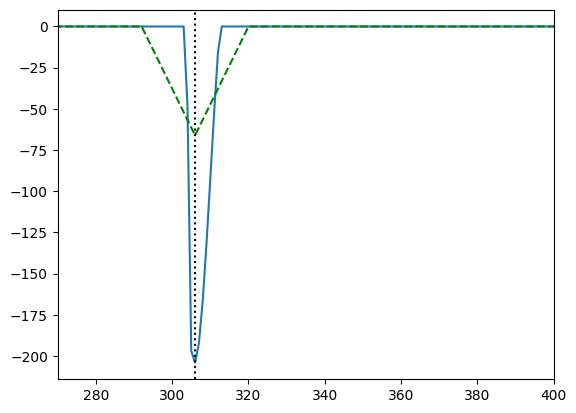

In [72]:
import matplotlib.pyplot as plt

plt.plot(contact_force[0:650])
for i in range(len(damp_peak)):
    plt.axvline(x=damp_peak[i], color='r', linestyle='--')


### 미분관련 실험
# d_contact_force = np.diff(contact_force)
# d_force_peak, _ = find_peaks(d_contact_force, prominence=0.00001)
# plt.plot(d_contact_force[0:650])

# for i in range(len(d_force_peak)):
#     plt.axvline(x=d_force_peak[i], color='g', linestyle='--')

### linspace 관련 실험
MAX_force_ref = 66.0513
contact_duration = 30

before_contact = np.linspace(0, -1 * MAX_force_ref, int((contact_duration+1)/2))
after_contact = np.linspace(-1 * MAX_force_ref, 0, int((contact_duration+1)/2))

ref_plot = np.zeros(650)
ref_plot[(idx_peak_force - (int((contact_duration+1)/2))) + 1 : idx_peak_force + 1] = before_contact
ref_plot[idx_peak_force:(idx_peak_force + (int((contact_duration+1)/2)))] = after_contact

rmse = np.square(np.subtract(contact_force[idx_peak_force - int((contact_duration+1)/2) + 1:idx_peak_force + int((contact_duration+1)/2)], ref_plot[idx_peak_force - int((contact_duration+1)/2) + 1:idx_peak_force + int((contact_duration+1)/2)])).mean()

print(ref_plot[idx_peak_force - int((contact_duration+1)/2) + 1:idx_peak_force + int((contact_duration+1)/2)])
print(rmse)

plt.plot(ref_plot, color='g', linestyle='--')

real_data_before_contact = contact_force[idx_peak_force - int((contact_duration+1)/2):idx_peak_force]

    
plt.axvline(x=idx_peak_force, color='k', linestyle=':')
plt.xlim(270, 400)
plt.show()

In [73]:
MAX_force_ref = -60
contact_duration = 15

before_contact = np.linspace(0, -1 * MAX_force_ref, int((contact_duration+1)/2))
after_contact = np.linspace(-1 * MAX_force_ref, 0, int((contact_duration+1)/2))

real_data_before_contact = contact_force[idx_peak_force - int((contact_duration+1)/2):idx_peak_force]

# print(before_contact,after_contact)
print(real_data_before_contact)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -47.45296535403442, -196.9075769631824]


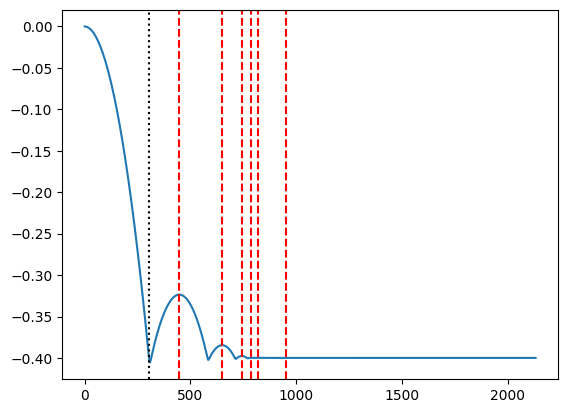

In [74]:
plt.plot(debris_pos[0:4000])

for i in range(len(pos_peak)):
    plt.axvline(x=pos_peak[i], color='r', linestyle='--')
plt.axvline(x=idx_peak_force, color='k', linestyle=':')
plt.show()